# Map2Loop geologic topology graphs to GNN inputs

## How to extract topology from 2D geographic maps and create 
> * Spatial adjacency matrix S of |V| x |V|, describing where geological units meet and how they are in contact. Possible values are integers from 0 to 4. 0 means units are not touching. 1, 2, 3, and 4 indicate a stratigraphic, unconformity, intrusive or faulted contact, respectively (Thiele et al., 2016). 
> * Temporal relationship matrix T of |V| x |V|, describing existing known and unknown age relationships between geological units. Possible values are floats -1, 0, 1 and None.
> * Feature matrix F of |V| x |X|, containing the feature vectors for each geological unit. 

### Map2Loop

In [1]:
import os
from map2loop.project import Project
%matplotlib inline

proj = Project( 
    loopdata_state='WA'
)

proj.update_config(
                    out_dir='./model-test',
                    overwrite=True,
                    bbox_3d={
                         "minx": 500000,
                         "miny": 7490000,
                         "maxx": 545000,
                         "maxy": 7520000,
                         "base": -3200,
                         "top": 1200,
                     },
                    proj_crs={'init': 'EPSG:28350'},
                    quiet=True
                  )

proj.run(
            aus=True,
            deposits="Fe,Cu,Au,NONE",
            dtb='',
            orientation_decimate=0,
            contact_decimate=5,
            intrusion_mode=0,
            interpolation_spacing=500,
            misorientation=30,
            interpolation_scheme='scipy_rbf',
            fault_decimate=5,
            min_fault_length=5000,
            fault_dip=90,
            pluton_dip=45,
            pluton_form='domes',
            dist_buffer=10,
            contact_dip=-999,
            contact_orientation_decimate=5,
            null_scheme='null',
            thickness_buffer=5000,
            max_thickness_allowed=10000,
            fold_decimate=5,
            fat_step=750,
            close_dip=-999,
            use_interpolations=True,
            use_fat=True
)

100%|██████████████████| 100/100 [00:34<00:00,  2.94it/s]


### Spatial data

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_spatial_relationships(graph_file):
    
    # Read graph file into graph object
    G = nx.read_gml(graph_file, label='id')
    # Create space between nodes for clearer displaying
    pos = nx.spring_layout(G,k=0.3,iterations=20)
    fig, ax = plt.subplots(1)
    nx.draw(G, pos, ax=ax, with_labels=True)
    
    # Get nodes geological names instead of ids
    labels = nx.get_node_attributes(G, 'LabelGraphics')
    labels = [lab['text'] for lab in labels.values()]
    # Create a map of old numeric labels to new descriptive ones to use as a figure legend
    name2num = {name: num + 1 for num, name in enumerate(labels)}
    legend_text = "\n".join(f"{v} - {k}" for k, v in name2num.items())
    # Format figure and add legend
    props = dict(boxstyle="round", facecolor="w", alpha=0.5)
    ax.text(
        1.15,
        0.95,
        legend_text,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=props,
    )
    plt.show()
    
    # Relabel nodes to their descriptive labels and return
    newlabels = dict(zip(G.nodes, labels))
    G = nx.relabel_nodes(G, newlabels)
    S = nx.to_pandas_adjacency(G).values
    return S

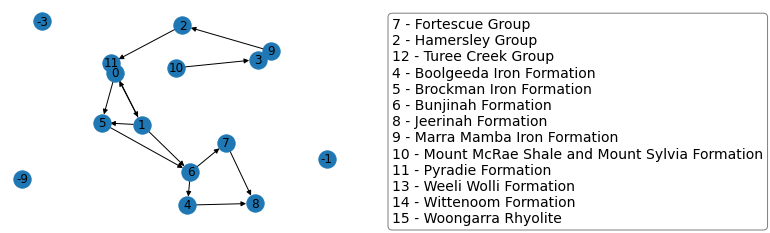

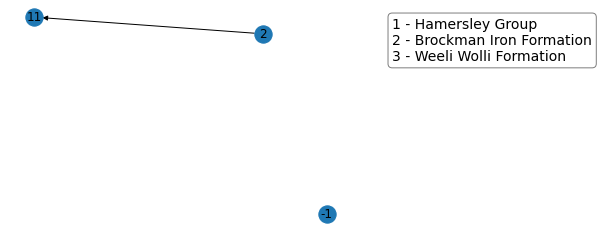

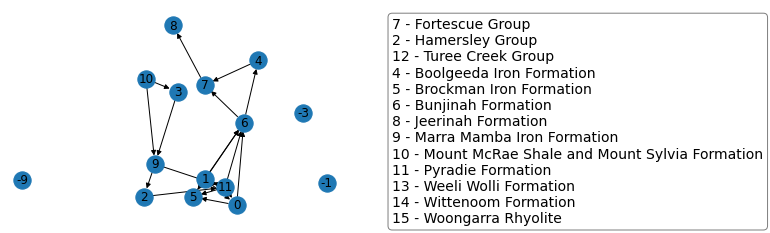

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 2. 0.]]
[[0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0. 0. 3. 3. 3. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0.]
 [3. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 3. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

ValueError: operands could not be broadcast together with shapes (13,13) (3,3) 

In [4]:
STRAT_CONTACT = 1
INTRSV_CONTACT = 2
FAULT_CONTACT = 3

strat_graph_file = proj.config.graph_path + "graph_strat_NONE.gml"
intrsv_graph_file = proj.config.graph_path + "graph_igneous_NONE.gml"
fault_graph_file = proj.config.graph_path + "graph_fault_NONE.gml"

_strat = get_spatial_relationships(strat_graph_file) * STRAT_CONTACT
_intrsv = get_spatial_relationships(intrsv_graph_file) * INTRSV_CONTACT
_fault = get_spatial_relationships(fault_graph_file) * FAULT_CONTACT

print(_strat)
print(_intrsv)
print(_fault)
_strat  + _intrsv

### Temporal data

In [26]:
import numpy as np

In [27]:
def get_temporal_relationships(graph_file):
    
     # Read graph file into graph object and parse node labels
    G = nx.read_gml(graph_file, label='id')
    labels = nx.get_node_attributes(G, 'LabelGraphics')
    labels = [lab['text'] for lab in labels.values()]
     
    # Change the labels from node id to geologic feature name
    newlabels = dict(zip(G.nodes, labels))
    G = nx.relabel_nodes(G, newlabels)
    
    # Create a zero matrix of the same shape as S
    T =  np.zeros(nx.to_pandas_adjacency(G).values.shape)
    
    # Get node to node mappings and create a map to identify nodes from their names
    edges = nx.to_pandas_edgelist(G).drop(['graphics'], axis=1)
    key_map = dict(zip(G.nodes, range(len(G.nodes))))
    
    for row in edges.iterrows():
        # Parse the edge into its origin and destination features
        values = (list(row))[1].tolist()
        source = values[0]
        target = values[1]
        # Get the associated index we mapped above
        # TODO: We will need to ensure that these mapped ids are
        # the same as is for the rows and cols of S, otherwise features 
        # would be out of order
        src_id = key_map[source]
        tar_id = key_map[target]
        # Set the origin node to 1 and the destination to -1
        T[src_id][tar_id] = 1
        T[tar_id][src_id] = -1
        
    return T

In [28]:
all_contacts = proj.config.graph_path + "graph_all_NONE.gml"

T = get_temporal_relationships(all_contacts)
print(T)

[[ 0.  0.  0.  0.  0.  1. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  0. -1.  1. -1.]
 [-1.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0. -1.  1.  0. -1. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  1.  0.  0.  0.  1.  0.]
 [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.  0.  1.  1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1. -1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]]


In [ ]:
# Properly define outputs
# Use the temporal information as the test labels